# Objetivo

Avaliar o desempenho de uma rede neural artificial MLP e comparar com os modelos anteriores.

Links úteis:

- https://www.tensorflow.org/api_docs/python/tf/keras

- https://mlflow.org/blog/deep-learning-part-1

- https://mlflow.org/docs/latest/deep-learning/tensorflow/quickstart/quickstart_tensorflow.html

- https://mlflow.org/docs/latest/deep-learning/tensorflow/guide/index.html

- https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

- https://www.tensorflow.org/tutorials/keras/keras_tuner

# Pacotes

In [7]:
#!pip install tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlflow
from deltalake import DeltaTable, write_deltalake
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import average_precision_score, recall_score, f1_score

2025-01-23 20:33:15.877522: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 20:33:15.881991: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 20:33:15.897736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737675195.918726   20340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737675195.925479   20340 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 20:33:15.946715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Leitura da base v1 e filtro de variáveis

Variáveis com valor acumulado de importância em ~90% e pelo valor de IV.

In [2]:
dados = DeltaTable("../1.Variaveis/tmp/dados_pp_v1").to_pandas()
dados.drop(['__index_level_0__', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver', 
            'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Gender_M',
            'Dependent_count'], axis=1, inplace=True)
dados.head()

,Customer_Age,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,Income_Category_1.< 40k,Income_Category_2. >= 40k & < 60k,Income_Category_3. >= 60k & < 80k,Income_Category_4. >= 80k & < 120k,Income_Category_5. >= 120k,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Attrition_Flag,type
0,-0.784196,1.403132,-1.337898,0.498943,0.963894,0.282975,-0.328225,-0.175537,-0.421450,1,0,0,0,0,0,0,1,0,0,Treino
1,0.720070,-0.525933,0.641818,1.408428,-0.165769,-1.527806,-0.194304,-0.208685,-1.054789,0,0,0,1,0,0,0,1,0,0,Treino
2,1.346848,-0.525933,-0.348040,0.498943,0.864865,0.894171,0.056797,-0.571459,-0.686436,0,0,0,1,0,0,0,0,1,0,Treino
3,0.218648,-0.525933,0.641818,-1.320028,-0.412731,0.369637,0.851953,0.252749,2.406712,1,0,0,0,0,0,0,1,0,0,Treino
4,-2.539173,0.117089,1.631675,1.408428,-0.858972,0.346832,-1.144306,-0.064053,-0.071911,1,0,0,0,0,1,0,0,0,0,Treino


## Separa bases

In [3]:
dados_treino = dados[dados.type == 'Treino'].drop(['type'], axis=1)
dados_val = dados[dados.type == 'Validacao'].drop(['type'], axis=1)

In [4]:
X_treino = dados_treino.drop(['Attrition_Flag'], axis=1)
y_treino = dados_treino['Attrition_Flag']

X_val = dados_val.drop(['Attrition_Flag'], axis=1)
y_val = dados_val['Attrition_Flag']

In [5]:
X_treino_new = X_treino.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

X_val_new = X_val.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

In [6]:
X_treino2, X_teste2, y_treino2, y_teste2 = train_test_split(X_treino_new, y_treino, test_size=.40, stratify=y_treino, random_state=1234)
y_treino2.value_counts(), y_teste2.value_counts()

(Attrition_Flag
 0    3684
 1     705
 Name: count, dtype: int64,
 Attrition_Flag
 0    2456
 1     470
 Name: count, dtype: int64)

In [7]:
X_treino2.shape

(4389, 18)

# Sequential API

In [7]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(10, activation='tanh', input_shape=X_treino2.shape[1:]),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-23 20:33:34.299009: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531 (2.07 KB)

 Trainable params: 531 (2.07 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[keras.metrics.AUC(curve='PR')])
              #metrics=[keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score, tf.keras.metrics.Precision, tf.keras.metrics.Recall])

In [14]:
X_treino2.shape[0]/50

87.78

In [17]:
history = model.fit(X_treino2, y_treino2, epochs=3,validation_data=(X_teste2, y_teste2), batch_size=32)

Epoch 1/3
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.5921 - loss: 0.3336 - val_auc: 0.6008 - val_loss: 0.3311
Epoch 2/3
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6202 - loss: 0.3318 - val_auc: 0.6108 - val_loss: 0.3234
Epoch 3/3
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6231 - loss: 0.3130 - val_auc: 0.6171 - val_loss: 0.3190


In [18]:
print(model.evaluate(X_treino2, y_treino2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6025 - loss: 0.3051
[0.3143392503261566, 0.631632924079895]


In [19]:
print(model.evaluate(X_teste2, y_teste2))

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6211 - loss: 0.3323
[0.3189784586429596, 0.6171499490737915]


In [20]:
print(model.evaluate(X_val_new, y_val))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6600 - loss: 0.3095
[0.3208531141281128, 0.6051487326622009]


In [21]:
results = []
tamanho = len(model.predict(X_val_new))
resultado_modelo = model.predict(X_val_new)

for i in range(tamanho):
    #print(i)
    results.append(resultado_modelo[i][0])

results = np.array(results)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [22]:
average_precision_score(y_true=y_val, y_score=results), recall_score(y_true=y_val, y_pred=results>.5), f1_score(y_true=y_val, y_pred=results>.5)

(np.float64(0.6067799112471224),
 np.float64(0.40865384615384615),
 np.float64(0.5214723926380368))

In [23]:
history.history

{'auc': [0.5955668091773987, 0.6154754757881165, 0.6256539225578308],
 'loss': [0.3367931842803955, 0.3245394825935364, 0.3175874948501587],
 'val_auc': [0.6008476614952087, 0.6108067035675049, 0.6171499490737915],
 'val_loss': [0.3311477303504944, 0.32338571548461914, 0.3189784586429596]}

In [24]:
main_metrics = {   
                    'tr_aucpr': history.history['auc'],
                    'vl_aucpr': history.history['val_auc']
                }

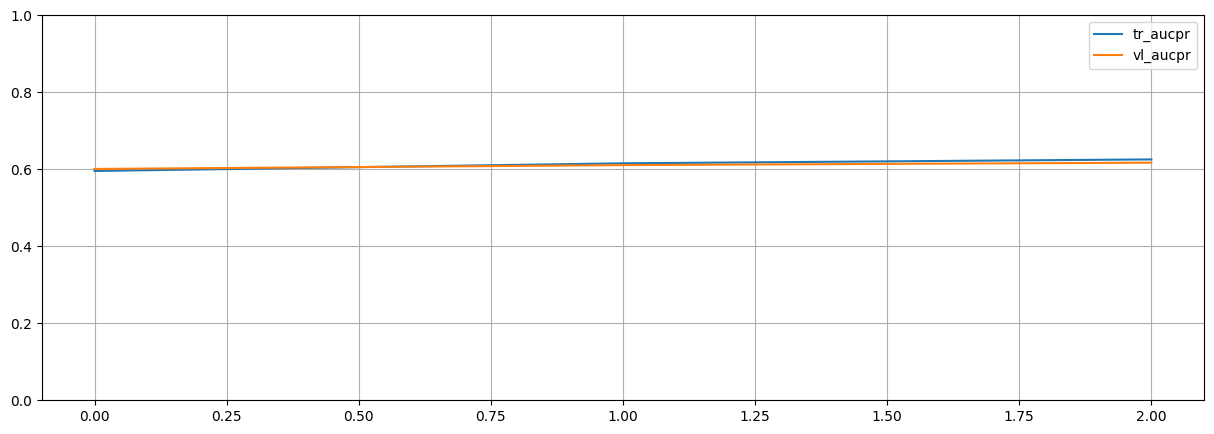

In [25]:
pd.DataFrame(main_metrics).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(loc='upper right')
plt.show()

# Log no MLflow

In [26]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(10, activation='tanh', input_shape=X_treino2.shape[1:]),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy',
              optimizer='sgd')
              #metrics=[keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score, tf.keras.metrics.Precision, tf.keras.metrics.Recall])

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
experiment = mlflow.create_experiment(name = 'Modelo_MLP',
                                      artifact_location = 'Artf_Modelo_MLP',
                                      tags = {'Environment': 'Development', 'Version': '1.0.0'}
                                      )

In [35]:
experiment

'497551797375184227'

In [ ]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'MLP2', experiment_id = experiment) as run: 

        model.fit(X_treino2, y_treino2, epochs=3, validation_data=(X_teste2, y_teste2), batch_size=32, callbacks=[mlflow.keras.MlflowCallback()])

        mlflow.tensorflow.log_model(model, "model", signature=signature)

2025/01/23 21:15:05 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/01/23 21:15:05 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/3
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3089

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3089 - val_loss: 0.3168
Epoch 2/3
115/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3185

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3166 - val_loss: 0.3147
Epoch 3/3
110/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2926

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2948 - val_loss: 0.3129


2025/01/23 21:15:07 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/01/23 21:15:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/01/23 21:15:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


MlflowException: All fields in the model signature's input schema must be of type TensorSpec.